### Read in all CTD data

In [1]:
import pandas as pd
from glob import glob
import gsw
import numpy as np
from geopy.distance import distance
from extraFuncs import zmld_boyer # this is the mixed layer depth function

df2012 = pd.read_csv('../../data/acousticData/2012_2013/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2012_v2.csv')
df2013 = pd.read_csv('../../data/acousticData/2012_2013/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2013_v2.csv')
df2012Acoustics = df2012.iloc[:, [0,1,2,3,4]]
df2013Acoustics = df2013.iloc[:, [0,1,2,3,4]]
df2018Acoustics = pd.read_csv('../../data/acousticData/2017_2019/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2017.csv')
df2017Acoustics = pd.read_csv('../../data/acousticData/2018/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2018.csv')
df2017Acoustics = df2017Acoustics[df2017Acoustics.Latitude!=999]
df2019Acoustics = pd.read_csv('../../data/acousticData/2017_2019/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2019.csv')
df2019Acoustics = df2019Acoustics[df2019Acoustics.Latitude!=999]

df2012Catch = df2012.iloc[:, [0,1,2,5,6,7,8]]
df2013Catch = df2013.iloc[:, [0,1,2,5,6,7,8]]
df2017Catch = pd.read_csv('../../data/catchData/2017_2019/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2017.csv')
df2017Catch = df2017Catch[df2017Catch.Latitude!=999]
df2019Catch = pd.read_csv('../../data/catchData/2017_2019/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2019.csv')
df2019Catch = df2019Catch[df2019Catch.Latitude!=999]

dfCTD = pd.concat([pd.read_csv(file) for file in glob('../../data/physicalData/*.csv')])
dfCTD = dfCTD[dfCTD['profile_id'].notna()]
dfCTD = dfCTD.drop(labels=['S_42'],axis=1)
dfCTD = dfCTD.astype({'pressure': float, 'latitude': float, 'longitude': float, 'S_41': float, 'T2_35': float,'T_28': float})
dfCTD['time'] = pd.to_datetime(dfCTD.time)
dfCTD['depth'] = -1*gsw.z_from_p(dfCTD.pressure, dfCTD.latitude)
dfCTD = dfCTD.sort_values(by='time')
dfCTD2017 = dfCTD[(dfCTD.time.dt.year == 2017) & (dfCTD.time > pd.to_datetime('8-24-2017').tz_localize ('UTC'))]
dfCTD2019 = dfCTD[(dfCTD.time.dt.year == 2019) & (dfCTD.time > pd.to_datetime('8-23-2019').tz_localize ('UTC'))]
dfCTD_clean = pd.concat([dfCTD2017,dfCTD2019])

### Read in the acoustic data and get mwd

In [ ]:
dfSurveys = pd.read_csv('../../data/acousticData/2017_2019/mbaIntegrationResults.csv')
dfSurveys = dfSurveys[dfSurveys.CLASS!= 'SURFTURB']
df2017 = dfSurveys[dfSurveys.SURVEY==201701]
df2019 = dfSurveys[dfSurveys.SURVEY==201901]

def mwd(df):
    df['depth'] = (df.LAYER*5)-2.5
    df['weightedSA'] =df.PRC_NASC*df.depth
    df = df.groupby(['INTERVAL',"END_LONGITUDE", "END_LATITUDE","END_TIME"])[["PRC_NASC", "weightedSA"]].sum()
    df['mwd'] = df.weightedSA/df.PRC_NASC
    df = df.reset_index()
    df = df.drop(columns='weightedSA')
    df = df.rename(columns = {'END_LONGITUDE':'Longitude','END_LATITUDE':'Latitude'})
    df = df[df.Latitude!=999]
    return df

df2017mwd = mwd(df2017)
df2019mwd = mwd(df2019)

### CTD gridding

In [55]:
def ctdStationRadius(df):
    dfStations = df[['profile_id','latitude','longitude','time']].drop_duplicates()
    dists = []
    for year in df.time.dt.year.unique():
        dfCur = dfStations[dfStations.time.dt.year == year]
        nPoints = len(dfCur.latitude)
        for i in range(nPoints):
            curDists = []
            for ii in range(nPoints):
                if ii == i:
                    continue
                curDists.append(distance((dfCur.latitude.values[i],dfCur.longitude.values[i]),(dfCur.latitude.values[ii],dfCur.longitude.values[ii])).nm)
            dists.append(np.min(curDists))
    dfStations['TrackRadius'] = np.array(dists)/2
    
    S_max, S_min, S_surf, S_bot, S_mean, T_min, T_max, T_surf, T_bot, T_mean,mld = [[] for i in range(11)]

    for pid in df.profile_id.unique():
        dfCur = df[(df.profile_id==pid)].sort_values('pressure')
        S_max.append(dfCur.S_41.max())
        S_min.append(dfCur.S_41.min())
        S_surf.append(dfCur.S_41.mean())
        S_bot.append(dfCur[dfCur.depth > dfCur.depth.max()-5].S_41.mean())
        S_mean.append(dfCur.S_41.mean())
        T_max.append(dfCur.T_28.max())
        T_min.append(dfCur.T_28.min())
        T_surf.append(dfCur[dfCur.depth < 5].T_28.mean())
        T_bot.append(dfCur[dfCur.depth > dfCur.depth.max()-5].T_28.mean())
        T_mean.append(dfCur.T_28.mean())
        try:
            mld1, mld2 = zmld_boyer(dfCur.dropna().S_41.values, dfCur.dropna().T_28.values, dfCur.dropna().pressure.values)
        except:
            print(pid)
            mld2 = np.nan
        mld.append(mld2)
    dfStats = pd.DataFrame({'profile_id':df.profile_id.unique(),'S_max':S_max, 'S_min':S_min, 'S_surf':S_surf, 'S_bot':S_bot,'S_mean':S_mean, 'T_min':T_min, 'T_max':T_max, 'T_surf':T_surf, 'T_bot':T_bot,'T_mean':T_mean,'MLD':mld})
    return dfStations.merge(dfStats)

In [ ]:
from tqdm import tqdm_notebook as tqdm
dfStat = ctdStationRadius(dfCTD_clean)

meanSa, meanAcod, meanScod, meanPcod, meanPol,meanCap,meanMwd = ([] for i in range(7))
for  year in dfStat.time.dt.year.unique():
    dfEnvCur = dfStat[dfStat.time.dt.year == year]
    print(year)
    if year == 2017:
        dfFish = df2017Catch
        dfAcoustics = df2017Acoustics
        dfmwd = df2017mwd
    else:
        dfFish = df2019Catch
        dfAcoustics = df2019Acoustics
        dfmwd = df2019mwd
    for i in tqdm(range(len(dfEnvCur))):
        curSa, curAcod, curScod, curPcod, curPol,curCap,curMwd = [[] for k in range(7)]
        curSite = (dfEnvCur.latitude.values[i],dfEnvCur.longitude.values[i])        
        curRad = dfEnvCur.TrackRadius.values[i]
        for ii in range(len(dfFish)):
            if distance(curSite,(dfFish.Latitude.values[ii],dfFish.Longitude.values[ii])).nm <= curRad:
                curAcod.append(dfFish['Arctic cod (No. m^-2)'].values[ii])
                curScod.append(dfFish['Saffron cod (No. m^-2)'].values[ii])
                curPcod.append(dfFish['Pacific cod (No. m^-2)'].values[ii])
                curPol.append(dfFish['Pollock (No. m^-2)'].values[ii])
                curCap.append(dfFish['Capelin (No. m^-2)'].values[ii])
        for ii in range(len(dfAcoustics)):
            if distance(curSite,(dfAcoustics.Latitude.values[ii],dfAcoustics.Longitude.values[ii])).nm <= curRad:
                curSa.append(dfAcoustics['Fish 38 kHz sA (m^2 nmi^-2)'].values[ii])
        for ii in range(len(dfmwd)):
            if distance(curSite,(dfmwd.Latitude.values[ii],dfmwd.Longitude.values[ii])).nm <= curRad:
                curMwd.append(dfmwd.mwd.values[ii])
        meanSa.append(np.nanmean(curSa))
        meanAcod.append(np.nanmean(curAcod))
        meanScod.append(np.nanmean(curScod))
        meanPcod.append(np.nanmean(curPcod))
        meanPol.append(np.nanmean(curPol))
        meanCap.append(np.nanmean(curCap))
        meanMwd.append(np.nanmean(curMwd))
dfStat['meanSa'] = meanSa
dfStat['meanAcod'] = meanAcod
dfStat['meanScod'] = meanScod
dfStat['meanPcod'] = meanPcod
dfStat['meanPol'] = meanPol
dfStat['meanCap'] = meanCap
dfStat['meanMwd'] = meanMwd
#dfStat.to_csv('analysisFiles/dfStat.csv')

In [ ]:
from tqdm import tqdm_notebook as tqdm
dfStat = ctdStationRadius(dfCTD_clean)

meanSa, meanAcod, meanScod, meanPcod, meanPol,meanCap = ([] for i in range(6))
for  year in dfStat.time.dt.year.unique():
    dfEnvCur = dfStat[dfStat.time.dt.year == year]
    print(year)
    if year == 2017:
        dfFish = df2017Catch
        dfAcoustics = df2017Acoustics
    else:
        dfFish = df2019Catch
        dfAcoustics = df2019Acoustics
    for i in tqdm(range(len(dfEnvCur))):
        curSa, curAcod, curScod, curPcod, curPol,curCap = [[] for k in range(6)]
        curSite = (dfEnvCur.latitude.values[i],dfEnvCur.longitude.values[i])        
        curRad = dfEnvCur.TrackRadius.values[i]
        for ii in range(len(dfFish)):
            if distance(curSite,(dfFish.Latitude.values[ii],dfFish.Longitude.values[ii])).nm <= curRad:
                curAcod.append(dfFish['Arctic cod (No. m^-2)'].values[ii])
                curScod.append(dfFish['Saffron cod (No. m^-2)'].values[ii])
                curPcod.append(dfFish['Pacific cod (No. m^-2)'].values[ii])
                curPol.append(dfFish['Pollock (No. m^-2)'].values[ii])
                curCap.append(dfFish['Capelin (No. m^-2)'].values[ii])
        for ii in range(len(dfAcoustics)):
            if distance(curSite,(dfAcoustics.Latitude.values[ii],dfAcoustics.Longitude.values[ii])).nm <= curRad:
                curSa.append(dfAcoustics['Fish 38 kHz sA (m^2 nmi^-2)'].values[ii])
        meanSa.append(np.nanmean(curSa))
        meanAcod.append(np.nanmean(curAcod))
        meanScod.append(np.nanmean(curScod))
        meanPcod.append(np.nanmean(curPcod))
        meanPol.append(np.nanmean(curPol))
        meanCap.append(np.nanmean(curCap))
dfStat['meanSa'] = meanSa
dfStat['meanAcod'] = meanAcod
dfStat['meanScod'] = meanScod
dfStat['meanPcod'] = meanPcod
dfStat['meanPol'] = meanPol
dfStat['meanCap'] = meanCap
dfStat.to_csv('analysisFiles/dfStat.csv')

In [5]:
dfStat2017 = dfStat[dfStat.time.dt.year == 2017]
dfStat2019 = dfStat[dfStat.time.dt.year == 2019]

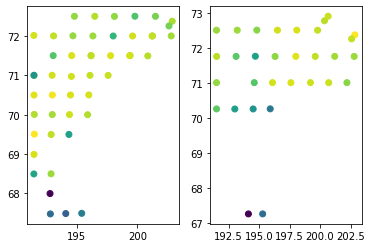

In [14]:
import matplotlib.pyplot as plt
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.scatter(dfStat2017.longitude, dfStat2017.latitude, c=np.log(dfStat2017.meanAcod))
ax2.scatter(dfStat2019.longitude, dfStat2019.latitude, c=np.log(dfStat2019.meanAcod))

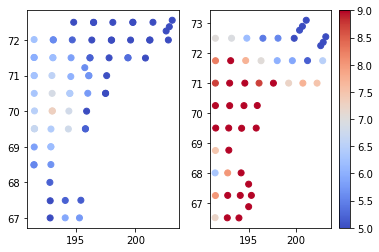

In [6]:
import matplotlib.pyplot as plt
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.scatter(dfStat2017.longitude, dfStat2017.latitude, c=dfStat2017.T_surf,vmin=5,vmax=9,cmap='coolwarm')
a = ax2.scatter(dfStat2019.longitude, dfStat2019.latitude, c=dfStat2019.T_surf,vmin=5,vmax=9,cmap='coolwarm')
plt.colorbar(a)

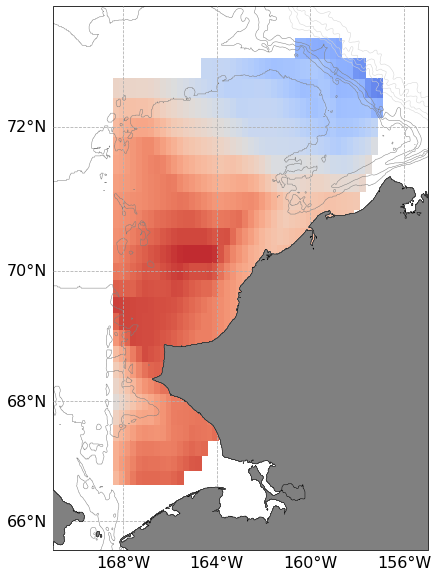

In [93]:
import sys
sys.path.insert(1, 'C:/Users/Robert/Documents/projects/rltools')
#sys.path.insert(1, 'C:/Users/robert.levine/work/repositories/rltools')
from akMaps import akMaps
mapper = akMaps.akMaps()
mapper.chukchiMesh(dfStat2019.latitude.values,dfStat2019.longitude.values,dfStat2019.T_surf.values,cmin=2,cmax=11,extent=[-155,-171,65.5,73.5])

C:\Users\rober\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


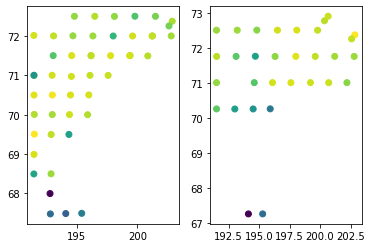

In [6]:
import matplotlib.pyplot as plt
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.scatter(dfStat2017.longitude, dfStat2017.latitude, c=np.log(dfStat2017.meanAcod))
ax2.scatter(dfStat2019.longitude, dfStat2019.latitude, c=np.log(dfStat2019.meanAcod))

(26.0, 33.0, 1.5, 11.5)

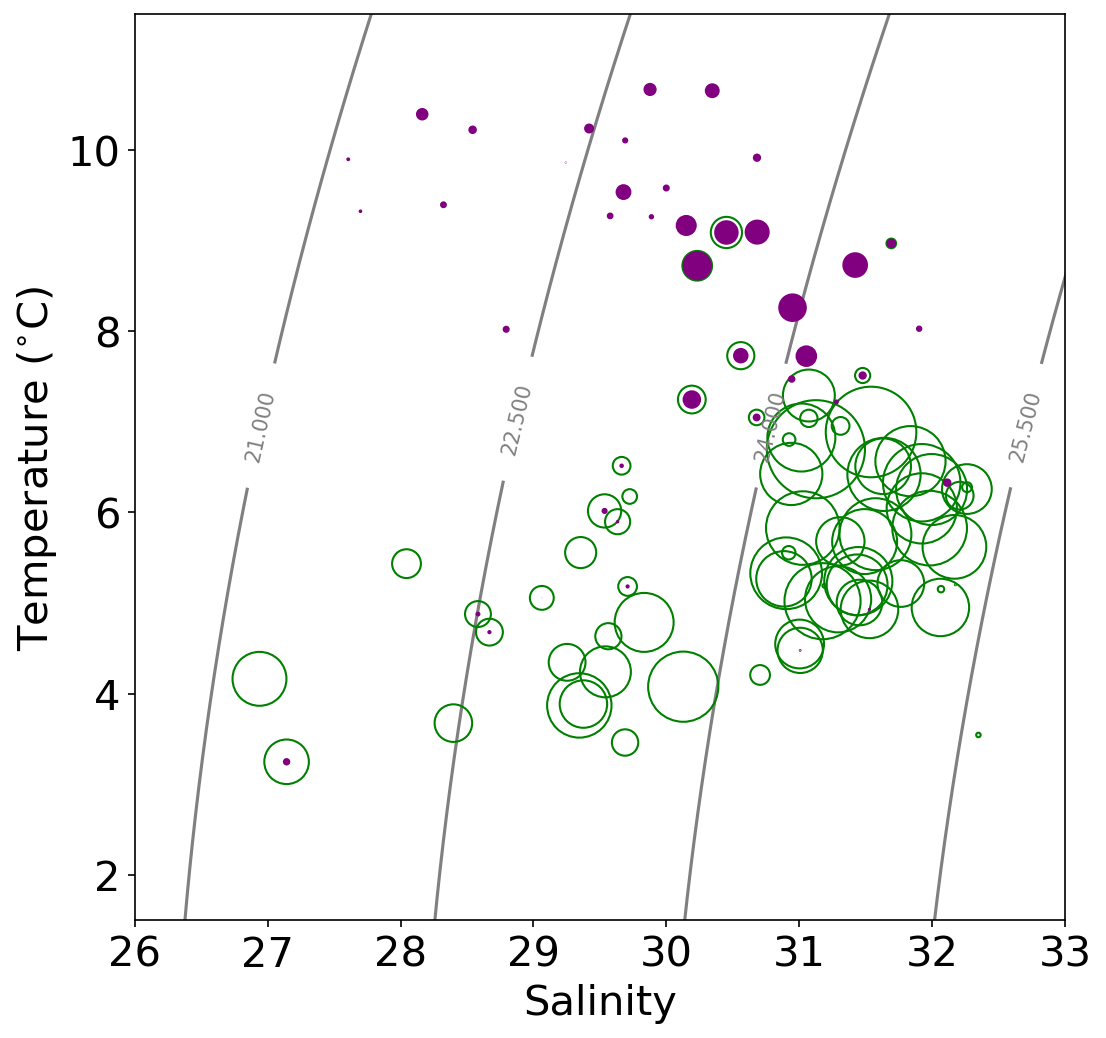

In [9]:
from matplotlib.lines import Line2D
fig = plt.figure(figsize=(8,8),dpi=150)
plt.scatter(dfStat.S_surf,dfStat.T_surf,s=(dfStat.meanAcod*100),facecolors='none', edgecolors='green')
plt.scatter(dfStat.S_surf,dfStat.T_surf,s=(dfStat.meanPol*100),facecolors='purple', edgecolors='purple')
#plt.scatter(dfStat.S_surf,dfStat.T_surf,s=(dfStat.meanScod**5),c='r')
#plt.scatter(dfStat.S_surf,dfStat.T_surf,s=(dfStat.meanPcod**5),c='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
x = np.linspace(25,35,50)
y = np.linspace(-1,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([26,33,1.5,11.5])

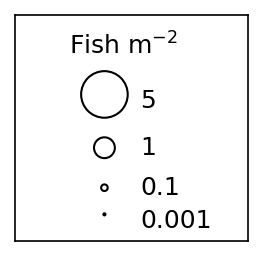

In [52]:
plt.figure(figsize=(2,2),dpi=150)
plt.scatter(27,7,.01*100,facecolors='none', edgecolors='k')
plt.scatter(27,7.2,.1*100,facecolors='none', edgecolors='k')
plt.scatter(27,7.5,1*100,facecolors='none', edgecolors='k')
plt.scatter(27,7.9,5*100,facecolors='none', edgecolors='k')
plt.text(26.8,8.2,'Fish m$^{-2}$',fontsize=12)
plt.text(27.2,6.9,'0.001',fontsize=12)
plt.text(27.2,7.15,'0.1',fontsize=12)
plt.text(27.2,7.45,'1',fontsize=12)
plt.text(27.2,7.8,'5',fontsize=12)
plt.axis([26.5,27.8,6.8,8.5])
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off